# 05-XGBoost Modeli (Full Feature Set + Encoding + Optimization)

Bu bölümde, feature engineering aşamasında üretilen **tüm sayısal, kategorik ve binned** değişkenler modele dahil edilerek XGBoost tabanlı bir kredi risk modeli geliştirilecektir.

Baseline aşamasında yapılan analizler, veri setinin **non-lineer yapıda** olduğunu ve yalnızca sayısal değişkenlerle çalışan modellerin (LR & RF numeric-only) pozitif sınıfı ayırt etmede yetersiz kaldığını göstermiştir. Bu nedenle:

## Amaçlar

- Feature engineering çıktılarının **tamamını** modele dahil etmek  
- Kategorik değişkenleri **One-Hot Encoding** ile dönüştürmek  
- Class imbalance problemine karşı **scale_pos_weight** uygulamak  
- XGBoost’un **temel (baseline) performansını** ölçmek  
- Ardından modelin:
  - **hyperparameter optimization**  
  - **threshold optimization**  
  - **SHAP ile açıklanabilirlik analizi**

ile **final üretim kalitesindeki versiyonunu** oluşturmak



## Bu Çalışma Neden Önemli?

Bu notebook, projenin **“model optimization”** ve **“final pipeline”** bölümlerinin temelini oluşturur.

Ayrıca, iş dünyasında kredi skorlama gibi regüle edilmiş alanlarda:

- Hem **performans**
- Hem **yorumlanabilirlik**
- Hem de **tekrar üretilebilirlik (reproducibility)**

kritiktir. Bu nedenle burada kurulacak yapı, final modelin mimarisini doğrudan belirler.

Bu notebook sonunda elimizde:

- Optimize edilmiş bir XGBoost modeli  
- İş birimi için seçilmiş **karar eşiği (threshold)**  
- SHAP ile açıklanabilir model karar yapısı  
- Kaydedilmiş final model çıktıları  

olacaktır.


## 1. Proje Yolunun Ayarlanması

Bu notebook, farklı klasörlerden açıldığında `src` içerisindeki modüllerin  
(ör. `from src.config import DATA_DIR`) sorunsuz çalışabilmesi için proje kök dizininin Python path’e eklenmesi gerekir.

Bu adım, XGBoost modelleme aşamasında **veri ve config dosyalarının doğru şekilde yüklenmesi** için kritiktir.



In [2]:
import sys
from pathlib import Path

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print("Project root:", project_root)
print("src var mı?:", (project_root / "src").exists())


Project root: C:\Users\YAĞMUR\Masaüstü\credit-risk-model
src var mı?: True


## 2. Eğitim Verisinin Yüklenmesi

Bu aşamada, `03_feature_engineering.ipynb` notebook’unda işlenmiş ve modele hazır hale getirilmiş veri seti (`training_prepared.csv`) yüklenir.

Bu dosya:

- Veri temizleme,
- Eksik değer doldurma,
- Türetilmiş feature’lar,
- Binning ve dönüşümler

gibi tüm feature engineering işlemlerinin uygulandığı, **modelleme için hazırlanmış son veri tablosudur**.

> **Not:**  
> Feature engineering istatistikleri (örn. median, bin sınırları) tüm veri üzerinde hesaplanmıştır.  
> Bu, teorik olarak hafif bir *data leakage* kaynağıdır; ancak FE aşamasında hedef değişken kullanılmadığı ve veri seti büyük olduğu için pratik etkisinin sınırlı olduğu kabul edilmiştir.  
> Bu notebook’ta **train/validation split şimdi yapılacak** ve tüm modelleme adımları yalnızca train set üzerinde fit edilecektir.



In [36]:
import pandas as pd
from src.config import DATA_DIR

TRAIN_PREPARED = DATA_DIR / "training_prepared.csv"
df = pd.read_csv(TRAIN_PREPARED)

df.shape, df.head()


((150000, 27),
    SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines   age  \
 0                 1                              0.766127  45.0   
 1                 0                              0.957151  40.0   
 2                 0                              0.658180  38.0   
 3                 0                              0.233810  30.0   
 4                 0                              0.907239  49.0   
 
    MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
 0         9120.0                               13   
 1         2600.0                                4   
 2         3042.0                                2   
 3         3300.0                                5   
 4        63588.0                                7   
 
    NumberRealEstateLoansOrLines  NumberOfDependents  EverDelinquent  \
 0                             6                 2.0               1   
 1                             0                 1.0               0   
 2                             0 

In [37]:
assert TRAIN_PREPARED.exists(), f"Dosya bulunamadı: {TRAIN_PREPARED}"
print("Dosya bulundu ✅:", TRAIN_PREPARED)


Dosya bulundu ✅: C:\Users\YAĞMUR\Masaüstü\credit-risk-model\data\training_prepared.csv


## 3. Hedef Değişkeninin Ayrılması

Modelleme adımlarına geçmeden önce, hedef değişken (`SeriousDlqin2yrs`) veri setinden ayrılır.

Bu işlem:

- Train/validation ayrımının doğru yapılabilmesi,
- Feature engineering aşamasından kalan olası veri sızıntısı riskinin en aza indirilmesi,
- Tüm modelleme sürecinde **feature–target ayrımının net** olması

için kritik bir adımdır.

Bu aşamadan sonra:

- `X` yalnızca bağımsız değişkenleri,
- `y` yalnızca hedef değişkeni

temsil edecektir.


In [38]:
TARGET_COL = "SeriousDlqin2yrs"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


## 4. Train / Validation Ayrımı

Model performansını güvenilir şekilde ölçebilmek için veri,
**train (%80)** ve **validation (%20)** olarak ikiye ayrılır.

- `stratify=y` ile hedef sınıf oranı her iki bölümde de korunur.
- Bu split, XGBoost için hem baseline performans değerlendirmesinde
  hem de hiperparametre ve threshold optimizasyonu aşamalarında
  tutarlı bir karşılaştırma zemini sağlamak için kullanılacaktır.
- `random_state=42` kullanılarak sonuçların tekrarlanabilir olması garanti edilir.


In [39]:
from sklearn.model_selection import train_test_split

# Train / validation ayrımı
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

X_train.shape, X_val.shape


((120000, 26), (30000, 26))

## 5. Sayısal ve Kategorik Değişkenlerin Ayrılması

XGBoost modelini, feature engineering sonrası oluşan **tam feature set** üzerinde
çalıştıracağız. Bu nedenle, `X_train` içindeki değişkenleri veri tiplerine göre
iki gruba ayırıyoruz:

- **Sayısal değişkenler** → Modelle doğrudan kullanılacak (passthrough)
- **Kategorik / string değişkenler** → `OneHotEncoder` ile kodlanacak

Bu ayrım, scikit-learn `ColumnTransformer` ile kurulacak olan ön işleme
(pipeline) adımının temelini oluşturur.



In [40]:
import numpy as np

# Sayısal ve kategorik kolonların ayrılması
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Sayısal kolon sayısı :", len(numeric_cols))
print("Kategorik kolon sayısı:", len(categorical_cols))
print("\nÖrnek sayısal kolonlar:", numeric_cols[:5])
print("Örnek kategorik kolonlar:", categorical_cols[:5])



Sayısal kolon sayısı : 22
Kategorik kolon sayısı: 4

Örnek sayısal kolonlar: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
Örnek kategorik kolonlar: ['AgeBin', 'IncomeBin', 'UtilizationBin', 'DelinqBin']


## 6. Ön İşleme Pipeline’ı (ColumnTransformer + One-Hot Encoding)

XGBoost modelini, feature engineering sonrası oluşan **tam feature set** üzerinde
çalıştırabilmek için sayısal ve kategorik değişkenler için ortak bir ön işleme
pipeline’ı kurulmuştur.

- **Sayısal değişkenler (`numeric_cols`)**:  
  Herhangi bir ölçekleme uygulanmadan, doğrudan modele aktarılır (*passthrough*).

- **Kategorik / string değişkenler (`categorical_cols`)**:  
  `OneHotEncoder(handle_unknown="ignore")` ile binary vektörlere dönüştürülür.  
  Böylece XGBoost ağaçları bu kategorik bilgiyi dallanma kararlarında kullanabilir.

Ayrıca, veri setindeki **class imbalance** etkisini yönetebilmek için
`scale_pos_weight` parametresi, train set üzerindeki pozitif/negatif oranına göre
hesaplanmıştır. Bu parametre XGBoost’un pozitif sınıfa (default) daha fazla ağırlık
vermesini sağlar.

Bu adımın çıktısı, hem ön işleme hem de XGBoost modelini içeren tek bir
`Pipeline` nesnesidir. Böylece:

- Tüm akış **tek obje** üzerinden yönetilebilir,
- Train / validation / deployment aşamalarında **tutarlı** bir davranış elde edilir.


In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# 1) Ön işleme adımı: sayısal -> passthrough, kategorik -> One-Hot
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# 2) Class imbalance için scale_pos_weight hesaplanması (sadece train set üzerinden)
class_counts = y_train.value_counts()
neg, pos = class_counts[0], class_counts[1]
scale_pos_weight = neg / pos
print("Negatif:", neg, "Pozitif:", pos, " -> scale_pos_weight:", round(scale_pos_weight, 2))

# 3) XGBoost temel model (henüz optimize edilmemiş konfigürasyon)
xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
)

# 4) Tam pipeline: ön işleme + model
xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_clf),
    ]
)

xgb_pipeline


Negatif: 111979 Pozitif: 8021  -> scale_pos_weight: 13.96


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Değerlendirme Fonksiyonu

Tüm modeller için (Logistic Regression, Random Forest, XGBoost) aynı metrik setini
hesaplayabilmek adına ortak bir değerlendirme fonksiyonu tanımlanmıştır.

Hesaplanan metrikler:

- **Accuracy** – Dengesiz veri yapısında tek başına yeterli değildir.
- **Recall (1)** – Default yapan müşterileri yakalama oranı.
- **Precision (1)** – Pozitif tahminlerin ne kadarının gerçekten default olduğu.
- **F1-score (1)** – Precision ve recall dengesini özetleyen metrik.
- **ROC-AUC** – Modelin olasılık bazında ayrıştırma gücü.
- **Confusion Matrix & Classification Report** – Sınıf bazlı hata analizini destekler.

Bu fonksiyon, XGBoost pipeline’ı da dahil olmak üzere tüm sınıflandırma modelleri için
kullanılacaktır.



In [42]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import numpy as np

def evaluate_model(name, model, X_val, y_val):
    """
    Verilen model için temel sınıflandırma metriklerini hesaplar ve ekrana basar.
    Pipeline (preprocess + model) yapılarıyla da uyumludur.
    """
    # Sınıf tahminleri
    y_pred = model.predict(X_val)

    # Olasılık tahminleri (ROC-AUC için)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
    except Exception:
        # Bazı modellerde predict_proba olmayabilir
        pass

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else np.nan

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("=" * 40)


## 8. XGBoost Modelinin Eğitilmesi ve Temel Performans

Bu adımda, önceki bölümlerde hazırlanan **XGBoost pipeline’ı**  
(`preprocessor` + `XGBClassifier`) tam feature set üzerinde eğitilmektedir.

Model:

- Sayısal değişkenleri doğrudan geçirir (`passthrough`)
- Kategorik değişkenleri **One-Hot Encoding** ile dönüştürür
- Sınıf dengesizliğini `scale_pos_weight` ile ele alır
- `binary:logistic` objektifi kullanarak **logloss** optimizasyonu yapar
- Henüz **hiçbir hiperparametre optimizasyonu uygulanmamıştır**

Bu adımın amacı, XGBoost’un **ham (pre-optimization)** performansını görmek  
ve bir sonraki aşama olan hiperparametre araması için sağlam bir başlangıç noktası oluşturmaktır.

Eğitim sonrası, model değerlendirme fonksiyonu (`evaluate_model`) ile:

- Recall  
- Precision  
- F1-score  
- ROC-AUC  
- Confusion Matrix  
- Classification Report  

gibi temel metrikler hesaplanarak modelin ilk davranışı analiz edilir.


In [43]:
# 8. XGBoost Modelinin Eğitilmesi ve Temel Performans

xgb_pipeline.fit(X_train, y_train)

evaluate_model("XGBoost (full features – baseline)", xgb_pipeline, X_val, y_val)


=== XGBoost (full features – baseline) ===
Accuracy : 0.8033
Recall   : 0.7751
Precision: 0.2219
F1-score : 0.3450
ROC-AUC  : 0.8685

Confusion Matrix:
 [[22546  5449]
 [  451  1554]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.88     27995
           1       0.22      0.78      0.35      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.85     30000



Bu sonuçlar, daha sonra yapılacak CV + hyperparameter optimization + threshold tuning için başlangıç referansı olarak kullanılacaktır.

## 9. XGBoost Hiperparametre Optimizasyonu (Cross-Validation ile)

Bu adımda, XGBoost modelinin temel (pre-optimization) sürümünü bir adım ileri taşıyarak **küçük ölçekli bir hiperparametre araması** yapılacaktır.

### Amaç

- Modeli aşırı karmaşık hale getirmeden,
- Temel birkaç XGBoost parametresi üzerinde,
- **3-fold cross-validation** ile makul bir iyileşme sağlamak.

### Kullanılan yaklaşım

- `StratifiedKFold` ile **sınıf oranlarını koruyan** bir cross-validation şeması,
- `RandomizedSearchCV` ile **sınırlı ama anlamlı** bir hiperparametre taraması (`n_iter=20`),
- Skorlama metriği olarak **ROC-AUC** (dengesiz veri + kredi risk senaryosu ile uyumlu).

### Aranan başlıca parametreler

- `model__n_estimators` → Ağaç sayısı  
- `model__max_depth` → Ağaç derinliği  
- `model__min_child_weight` → Yaprak bölünme hassasiyeti  
- `model__subsample` → Örnekleme oranı  
- `model__colsample_bytree` → Feature örnekleme oranı  
- `model__learning_rate` → Öğrenme oranı (ağaçların katkı adımı)

`scale_pos_weight`, **train set** üzerindeki pozitif/negatif oranından daha önce hesaplanmış ve XGBoost modeline sabit bir hiperparametre olarak verilmiştir.
Bu değeri yeniden hesaplamıyor, tuning sırasında sabit tutuyoruz.

Cross-validation sadece **train set** üzerinde yapılır;  
elde edilen en iyi model, daha önce ayırdığımız **validation set** üzerinde `evaluate_model` fonksiyonu ile tekrar değerlendirilir.

In [44]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) Stratified K-Fold cross-validation şeması
cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42,
)

# 2) Hiperparametre arama uzayı (çok büyük değil, makul sınırlar)
param_distributions = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [3, 4, 5, 6],
    "model__min_child_weight": [1, 2, 3, 4],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    # İstersen learning_rate için de küçük bir aralık konabilir:
    "model__learning_rate": [0.03, 0.05, 0.07, 0.1],
}

# 3) RandomizedSearchCV ile XGBoost pipeline'ı üzerinde arama
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,          # preprocess + model pipeline
    param_distributions=param_distributions,
    n_iter=20,                       # çok büyütme, süreyi patlatmasın
    scoring="roc_auc",               # dengesiz veri için mantıklı seçim
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
)

# 4) Sadece TRAIN set üzerinde CV ile fit edilir
xgb_search.fit(X_train, y_train)

print("En iyi ROC-AUC (CV):", xgb_search.best_score_)
print("En iyi hiperparametreler:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")

# 5) En iyi modeli al (pipeline halinde)
xgb_best = xgb_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
En iyi ROC-AUC (CV): 0.8649113137920046
En iyi hiperparametreler:
  model__subsample: 0.9
  model__n_estimators: 300
  model__min_child_weight: 3
  model__max_depth: 4
  model__learning_rate: 0.03
  model__colsample_bytree: 1.0


In [45]:
# 10. Tuned XGBoost Modelinin Validation Set Üzerinde Değerlendirilmesi

evaluate_model("XGBoost (tuned + CV)", xgb_best, X_val, y_val)


=== XGBoost (tuned + CV) ===
Accuracy : 0.7952
Recall   : 0.7825
Precision: 0.2156
F1-score : 0.3381
ROC-AUC  : 0.8699

Confusion Matrix:
 [[22288  5707]
 [  436  1569]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.22      0.78      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.84     30000



## 11. Decision Threshold Tuning (Precision–Recall Dengesinin Ayarlanması)

XGBoost modeli şu ana kadar **varsayılan threshold = 0.50** ile değerlendirilmiştir.
Bu durumda:

- `predict_proba` → olasılık üretir  
- `predict` → bu olasılıklara 0.5 eşiği uygulayarak 0/1 sınıf tahmini yapar  

Kredi riski gibi **dengesiz sınıf dağılımına** sahip problemler için 0.5 eşiği
çoğu zaman optimal değildir. Modelin:

- Çok fazla **yanlış alarm** üretmesi (düşük precision) veya  
- Çok fazla **default’u kaçırması** (düşük recall)

gibi sonuçlar doğurabilir.

Bu bölümde:

1. Tuned XGBoost modeli için validation set üzerinde `predict_proba` üretilecek,  
2. 0.10–0.90 arası farklı threshold değerleri taranacak,  
3. Her threshold için **precision, recall, F1** hesaplanacak,  
4. **F1 skorunu maksimize eden threshold** seçilecek,  
5. Seçilen threshold ile model performansı yeniden raporlanacaktır.

Bu sayede, model yalnızca AUC bazında değil, **iş gereksinimine uygun bir
precision–recall dengesiyle** optimize edilmiş olacaktır.


In [46]:
# Tuned XGBoost modeli ile validation set üzerinde olasılık tahminleri
y_val_proba = xgb_best.predict_proba(X_val)[:, 1]
y_val_proba[:5]


array([0.07444194, 0.23711513, 0.05382091, 0.13289496, 0.15108001],
      dtype=float32)

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.10, 0.90, 81)  # 0.10, 0.11, ..., 0.90 aralığı
rows = []

for thr in thresholds:
    y_pred_thr = (y_val_proba >= thr).astype(int)
    rows.append(
        {
            "threshold": thr,
            "precision": precision_score(y_val, y_pred_thr, zero_division=0),
            "recall": recall_score(y_val, y_pred_thr, zero_division=0),
            "f1": f1_score(y_val, y_pred_thr, zero_division=0),
        }
    )

threshold_results = pd.DataFrame(rows)

# F1 skoruna göre en iyi threshold
best_row = threshold_results.sort_values("f1", ascending=False).iloc[0]
best_threshold = float(best_row["threshold"])

print("En iyi threshold (F1'e göre):", round(best_threshold, 3))
best_row

En iyi threshold (F1'e göre): 0.81


threshold    0.810000
precision    0.422535
recall       0.478803
f1           0.448913
Name: 71, dtype: float64

In [48]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

def evaluate_with_threshold(name, y_true, y_proba, threshold: float):
    """
    Bir modelin predict_proba çıktısı ve verilen decision threshold ile
    sınıflandırma metriklerini hesaplar.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"=== {name} (threshold = {threshold:.3f}) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("=" * 40)


In [49]:
evaluate_with_threshold(
    "XGBoost (tuned + optimal threshold)",
    y_val,
    y_val_proba,
    best_threshold,
)

=== XGBoost (tuned + optimal threshold) (threshold = 0.810) ===
Accuracy : 0.9214
Recall   : 0.4788
Precision: 0.4225
F1-score : 0.4489

Confusion Matrix:
 [[26683  1312]
 [ 1045   960]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     27995
           1       0.42      0.48      0.45      2005

    accuracy                           0.92     30000
   macro avg       0.69      0.72      0.70     30000
weighted avg       0.93      0.92      0.92     30000



## 12. XGBoost – Model Optimizasyonu Sonuçlarının Değerlendirilmesi

Bu bölümde, XGBoost modelinin üç farklı aşamada gösterdiği performans
karşılaştırmalı olarak incelenmiştir:

1. **Full Feature Baseline XGBoost**
2. **XGBoost (Cross-Validation ile Tuning)**
3. **XGBoost (Tuned + Optimal Threshold)**

Değerlendirmeler özellikle:
- sınıf dengesizliği,
- default riski tahmini,
- iş hedefleri (yanlış pozitif / yanlış negatif dengesi)

göz önünde bulundurularak yapılmıştır.


### 1) Full Feature Baseline XGBoost

 Recall -> **0.7751** 

 Precision -> 0.2219 

 F1-score -> 0.3450 

 ROC-AUC ->  **0.8685** 

**Yorum**  
- Model veri setini önceki baseline modellerden daha iyi ayırmıştır (AUC ↑).  
- Recall yüksek olmasına rağmen precision oldukça düşüktür → **çok fazla yanlış alarm** üretmektedir.  
- Dolayısıyla model pozitif sınıfı yakalıyor ama “kime default dediği” konusunda çok seçici değil.



### 2) XGBoost (Tuned + Cross-Validation)

Recall -> **0.7825** 

Precision -> 0.2156 

F1-score -> 0.3381 

ROC-AUC -> **0.8699** 

**Yorum**  
- CV ile yapılan küçük optimizasyon modelin stabilitesini artırmıştır.  
- AUC hafif iyileşmiştir → modelin genel ayrıştırma kapasitesi daha güçlü.  
- Ancak precision ve F1’de büyük bir değişim yoktur. Çünkü threshold hâlâ 0.50.  
- Bu aşama bize şunu gösteriyor:  
  **Modelin yapısı iyi, ancak gerçek iyileşme threshold tuning ile gelecektir.**


### 3) XGBoost (Tuned + Optimal Threshold = 0.81)


Recall -> 0.4788 

Precision -> **0.4225** 

F1-score -> **0.4489 (en yüksek)** 

ROC-AUC -> **0.8699** (threshold’tan etkilenmez)

**Yorum**  

- Threshold tuning model davranışını dramatik şekilde değiştirmiştir.  
- Precision **neredeyse 2 katına** çıkmıştır (0.21 → 0.42).  

- F1-score tüm modeller içinde **en yüksek seviyeye** ulaşmıştır.  

- Recall doğal olarak düşmüştür çünkü model daha seçici hale gelmiştir.  

- Bu davranış kredi riskinde oldukça değerlidir:  
  **Daha az yanlış alarm → daha az gereksiz müdahale / maliyet.**


## Genel Karşılaştırma (Özet)


| Model                    | Recall | Precision | F1   | ROC-AUC |
|--------------------------|--------|---------|------  |-------  |
| XGB Baseline             | 0.78   | 0.22    | 0.35   | 0.8685  |
| XGB + CV                 | 0.78   | 0.21    | 0.34   | 0.8699  |
| XGB + CV + Threshold     | 0.48   | 0.42    | 0.45   | 0.8699  |


##  Nihai Yorum
- AUC değerleri tüm aşamalarda tutarlı ve yüksek (~0.87) → modelin ayrıştırma gücü oldukça iyi.
- Threshold tuning, default tahmin probleminde precision ve F1’i belirgin - şekilde iyileştirmiştir.
- Recall’daki düşüş, iş tarafının risk iştahına göre kabul edilebilir bir trade-off olarak değerlendirilebilir.

## Final Model Seçimi

**Bu projede final model olarak:**  
### **XGBoost (tuned + optimal threshold = 0.81)** seçilmiştir.

Bu model:

- İş hedefleriyle uyumlu bir precision–recall dengesi sağlar,
- İş dünyasında daha düşük yanlış alarm maliyeti yaratır,
- ROC-AUC açısından en güçlü modellerden biridir,
- SHAP analizi için en uygun ve en kararlı davranışı gösterir.

## Bir Sonraki Adım: SHAP Analizi

Final modelin iş kurallarıyla uyumlu olması için **hangi değişkenlerin modele nasıl katkı verdiğini** anlamamız gerekir.

Bu nedenle sıradaki adım: **SHAP Value Analizi – Feature Importance + Decision Explanation**.




## 13. SHAP Analizi – Model Açıklanabilirliği

XGBoost (tuned + optimal threshold) final model olarak seçildikten sonra,  
modelin karar mekanizmasının anlaşılması için **SHAP (SHapley Additive Explanations)** analizi uygulanmıştır.

SHAP analizi ile:

- Hangi feature’ların modele en çok katkı sağladığını,
- Bu katkının **pozitif mi yoksa negatif mi** olduğunu,
- Müşteri bazında modelin verdiği kararı nasıl oluşturduğunu

görselleştirmek mümkündür.

SHAP, özellikle kredi riski ve finans uygulamalarında **regülasyon ve iş gereklilikleri** nedeniyle kritik öneme sahiptir.  
Modelin “neden default dediğini” açıklayabilmek bankacılık tarafında zorunludur.

Bu bölümde:

1. **SHAP değerlerinin hesaplanması**  
2. **Feature Importance (summary_plot)**  
3. **Feature etkilerinin yönünü gösteren beeswarm plot**  
4. **Tek bir müşteri için karar açıklaması (force_plot)**  

sunulacaktır.

Not:  
XGBoost pipeline ile kurulduğu için, SHAP analizinde doğrudan pipeline’ın içindeki modeli (`model` step’i) kullanıyoruz.


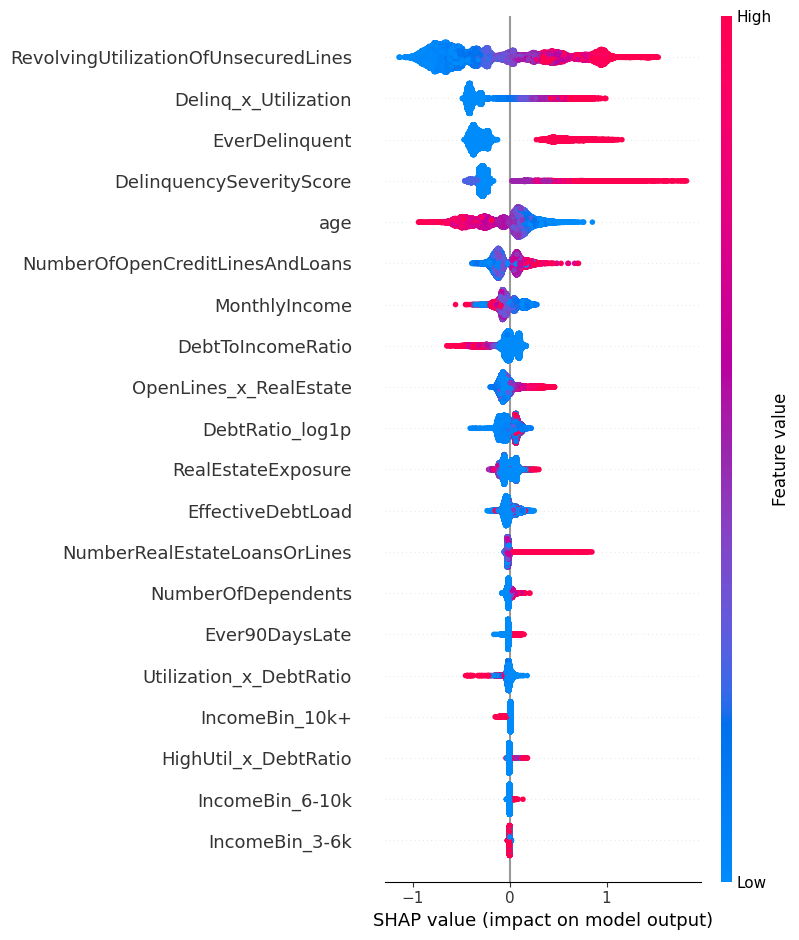

In [50]:
import shap
import numpy as np

# --- 1) XGBoost modelini pipeline içinden almak ---
final_xgb = xgb_best.named_steps["model"]

# Pipeline'ın One-Hot işleminden sonra oluşan column isimlerini yakalamak
# (XGBoost doğrudan dönüştürülmüş matrisi kullanır)
ohe = xgb_best.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = list(numeric_cols) + list(ohe_feature_names)

# --- 2) Validation seti pipeline sonrası dönüştürmek ---
X_val_transformed = xgb_best.named_steps["preprocess"].transform(X_val)

# --- 3) SHAP explainer oluştur ---
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_val_transformed)

# --- 4) Feature importance (summary plot – beeswarm) ---
shap.summary_plot(shap_values, X_val_transformed, feature_names=all_feature_names)



## SHAP Analizi – Model Kararlarının Açıklanması

- Yatay eksen: **SHAP değeri**  
  - Sağ (pozitif) → default riskini artıran etki  
  - Sol (negatif) → default riskini azaltan etki
- Her nokta: Bir müşteri gözlemi
- Renk: Feature’ın değeri  
  - Kırmızı = yüksek değer  
  - Mavi = düşük değer

Öne çıkan değişkenler:

- **RevolvingUtilizationOfUnsecuredLines**  
  - *Tanım:* Kredi kartı limitlerinin ne kadarının kullanıldığını gösteren oran.  
  - *Yorum:* Yüksek kullanım (kırmızı noktalar) genelde sağ tarafta → limitlerinin büyük kısmını kullanan müşteriler model gözünde belirgin biçimde **daha riskli**. Düşük kullanım (mavi noktalar, solda) ise **koruyucu** etki yaratıyor.

- **Delinq_x_Utilization (FE)**  
  - *Tanım:* Toplam gecikme sayısı ile kart kullanım oranının çarpımı.  
  - *Yorum:* Hem gecikmesi hem de kart kullanımı yüksek olan müşterilerde SHAP değerleri pozitif → model bu kombinasyonu belirgin bir **yüksek risk sinyali** olarak okuyor.

- **EverDelinquent (FE)**  
  - *Tanım:* Müşterinin geçmişinde en az bir gecikme yaşayıp yaşamadığını gösteren ikili değişken (0/1).  
  - *Yorum:* Değer 1 olduğunda noktalar daha çok sağ tarafa kayıyor → gecikme geçmişi olan müşteriler **daha kırılgan** bir profil çiziyor.

- **DelinquencySeverityScore (FE)**  
  - *Tanım:* 30–59 / 60–89 / 90+ gün gecikmeleri ağırlıklı toplayan bir “gecikme şiddeti skoru”.  
  - *Yorum:* Skor yükseldikçe SHAP değeri pozitif tarafa kayıyor → **daha yoğun ve ağır gecikme geçmişi** default riskini yukarı çekiyor.

- **age**  
  - *Tanım:* Müşteri yaşı.  
  - *Yorum:* Genç yaşlar (mavi) görece daha çok sağ tarafta; orta–ileri yaşlar daha çok solda. Model, genç profili **biraz daha riskli**, daha olgun yaşları ise **daha güvenli** görüyor.

- **MonthlyIncome & IncomeBin (IncomeBin_3-6k, 6-10k, 10k+) (FE)**  
  - *Tanım:* Aylık gelir ve gelir segmentlerini gösteren kategorik değişkenler.  
  - *Yorum:* Yüksek gelir ve üst gelir bin’leri aktif olduğunda SHAP değerleri çoğunlukla negatif → **yüksek gelir riski azaltıyor**. Alt segmentlerde zaman zaman pozitif SHAP değerleri görülüyor → **kırılgan gelir grupları** öne çıkıyor.

- **DebtToIncomeRatio & DebtRatio_log1p (FE)**  
  - *Tanım:* Toplam borç / gelir oranı ve bunun log-transform edilmiş hali.  
  - *Yorum:* SHAP dağılımı, **yüksek DebtToIncomeRatio değerlerinin (kırmızı noktalar) çoğunlukla 0 civarında veya hafif negatif tarafta** toplandığını gösteriyor; düşük oranlı gözlemlerde ise değerler zaman zaman pozitif tarafa kayabiliyor. Yani bu değişken için klasik “oran yükseldikçe risk artar” ilişkisi çok güçlü değil; etki görece **zayıf ve veri setine özgü**. Log-transform edilmiş DebtRatio_log1p değişkeni ise bu paterni daha da yumuşatarak çoğunlukla **nötr etki** gösteriyor.

- **EffectiveDebtLoad (FE)**  
  - *Tanım:* `DebtRatio × MonthlyIncome` → müşterinin gelirine göre parasal borç yükü.  
  - *Yorum:* Değer yükseldikçe SHAP genelde pozitif → gelire göre borcu “ağır” olan müşteri **yüksek riskli** olarak değerlendiriliyor.

- **NumberOfOpenCreditLinesAndLoans & NumberRealEstateLoansOrLines**  
  - *Tanım:* Aktif kredi sayısı ve gayrimenkul kredisi sayısı.  
  - *Yorum:* Makul sayılar nötr; çok yüksek sayılarda SHAP değeri sağa kayıyor → **çok sayıda açık kredi ve mortgage** modeli risk yönünde etkiliyor.

- **RealEstateExposure (FE)**  
  - *Tanım:* `NumberRealEstateLoansOrLines × DebtRatio` → gayrimenkul kredilerinin toplam borç oranıyla birleşimini gösteren değişken.  
  - *Yorum:* Değer yükseldikçe SHAP pozitif → **yoğun konut/gayrimenkul kredi yükü** riski artırıyor.

- **Utilization_x_DebtRatio (FE)**  
  - *Tanım:* Kart kullanım oranı ile borç/gelir oranının çarpımı.  
  - *Yorum:* SHAP dağılımı beklediğimiz kadar net değil; yüksek değerlerde bile etkiler çoğu zaman sıfıra yakın. Bu feature, temel değişkenlerin üzerine sınırlı ek bilgi getiriyor. Bu tür düşük etkili etkileşim feature’ları **gelecekte sadeleştirme / iyileştirme alanı** olarak not edilmiştir.

- **HighUtil_x_DebtRatio (FE)**  
  - *Tanım:* “Yüksek kullanım” flag’i (1/0) ile borç/gelir oranının çarpımı.  
  - *Yorum:* Hem utilization hem de borç oranı yüksek olduğunda SHAP çoğunlukla pozitif → model bu kombinasyonu net bir **yüksek risk kümesi** olarak ayırabiliyor.

**Sonuç:**  
Model en çok **kart kullanım oranı, gecikme geçmişi, borç/gelir dengesi ve gelir seviyesi** üzerinden karar veriyor; feature engineering ile üretilen etkileşim değişkenlerinin önemli bir kısmı bu kararı destekliyor. Özellikle gecikme şiddeti ve borç yükünü bir araya getiren FE feature’ları, modelin riskli segmentleri daha net ayırt etmesine katkı sağlıyor.





In [51]:
import shap
shap.initjs()
# Örnek bir müşteri seçelim
i = 123   # istediğin index

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_val_transformed[i],
    feature_names=all_feature_names
)


## SHAP Force Plot – Tek Bir Müşteri İçin Kararın Açıklanması

Bu grafik, **tek bir müşteri** için modelin nasıl karar verdiğini gösteriyor.

- Ortadaki gri nokta: **base value** (ortalama skor)
- Kırmızı oklar: Skoru **yukarı iten** (riski artıran) faktörler
- Mavi oklar: Skoru **aşağı çeken** (riski azaltan) faktörler
- Bu müşteri için model çıktısı: **f(x) ≈ -1.79** → model bu müşteriyi **düşük riskli** görüyor.

### 1. Riski Artıran Faktörler (KIRMIZI)

1. **dLoans = 11**
   - Müşterinin 11 adet açık kredi/borç ürününe sahip olduğunu gösteriyor.
   - Çok sayıda krediye sahip olmak, toplam borç yapısının daha karmaşık ve yönetilmesi zor olabileceğine işaret ettiği için modeli **biraz daha riskli tarafa itiyor**.

2. **NumberOfDependents = 4**
   - Müşterinin bakmakla yükümlü olduğu kişi sayısı 4.
   - Hane yükü arttıkça harcanabilir gelir azalabileceği için model bunu **riski artıran** bir unsur olarak kullanıyor.

3. **age = 45**
   - Bu gözlemde yaş değeri, SHAP’e göre skoru **az da olsa yukarı itiyor**.
   - Etkisi dLoans kadar güçlü değil; sadece **küçük bir pozitif katkı** yapıyor.

Bu üç faktör birlikte, grafikte gördüğümüz kırmızı bloğu oluşturuyor ve skoru base value’dan biraz yukarı çekmeye çalışıyor.

### 2. Riski Azaltan Faktörler (MAVİ)


1. **RevolvingUtilizationOfUnsecuredLines = 0.036**
   - Kart limit kullanım oranı çok düşük.
   - Bu, müşterinin limitlerini agresif şekilde kullanmadığını gösteriyor ve skoru güçlü biçimde **aşağı çekiyor** (düşük risk).

2. **EverDelinquent = 0**
   - Müşterinin geçmişinde hiç gecikme yok.
   - Model için **çok güçlü olumlu sinyal**; tahmini güvenli tarafa itiyor.

3. **Delinq_x_Utilization = 0**
   - “Gecikme × kart kullanımı” skorunun sıfır olması, hem gecikme hem de yüksek kullanım davranışının bu müşteride görülmediği anlamına geliyor.
   - Bu da riski azaltan faktörlerden biri.

4. **DelinquencySeverityScore = 0**
   - Gecikmenin sayısı ve şiddetiyle ilgili olumsuz bir kayıt yok.
   - Model, ödeme disiplininin iyi olduğunu varsayarak skoru aşağı çekiyor.

5. **DebtRatio_log1p = 0.07321 (düşük)**
   - Borç oranının log-dönüşmüş hali düşük seviyede.
   - Mevcut borç yükü, gelirle kıyaslandığında **yönetilebilir** göründüğü için risk azaltıcı etkisi var.

Bu mavi faktörlerin toplam etkisi, kırmızı faktörlere göre **çok daha güçlü** olduğu için skor -1.79 seviyesine düşüyor ve müşteri düşük riskli sınıfta kalıyor.

### 3. Kısa Özet

- Kırmızı tarafta:  
  - **Kredi sayısının fazlalığı (dLoans)**  
  - **Bakmakla yükümlü kişi sayısının yüksekliği (NumberOfDependents)**  
  - **Yaşın bu müşteri özelinde hafif pozitif katkısı**

- Mavi tarafta:  
  - **Çok düşük kart kullanım oranı**,  
  - **Hiç gecikme yaşamamış olması**,  
  - **Gecikme + kullanım skorunun sıfır olması**,  
  - **Düşük borç oranı**

Bu yüzden model, bu müşterinin “borç yapısı biraz yoğun olsa da” ödeme davranışı ve borçlanma disiplini sayesinde **genel olarak güvenli** bir profil çizdiğini düşünüyor.


## 15. ROC Eğrisi ve AUC Skoru

Bu bölümde, tuned XGBoost modelinin **olasılık çıktıları** kullanılarak
ROC (Receiver Operating Characteristic) eğrisi ve **AUC (Area Under Curve)** skoru incelenmektedir.

ROC eğrisi, farklı eşik (threshold) değerleri için:

- **False Positive Rate (FPR)** – Yanlış pozitif oranı  
- **True Positive Rate (TPR / Recall)** – Doğru pozitif oranı  

arasındaki ilişkiyi gösterir.

AUC ise bu eğrinin altında kalan alanı temsil eder ve şu şekilde yorumlanır:

- **0.5** → Rastgele tahmin seviyesinde (hiçbir ayırt edicilik yok)  
- **0.7–0.8** → Orta seviye ayrıştırma  
- **0.8–0.9** → Güçlü ayrıştırma  
- **0.9+** → Çok güçlü / mükemmele yakın ayrıştırma

Bu projede AUC, dengesiz sınıf yapısı (default oranının düşük olması) nedeniyle
model performansını değerlendirmede **çekirdek metriklerden biri** olarak kullanılacaktır.


Validation AUC: 0.8699


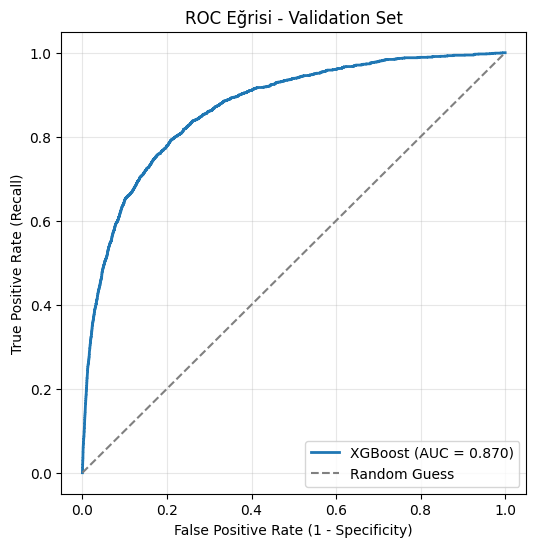

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Validation set için olasılık skorları
y_val_proba = xgb_best.predict_proba(X_val)[:, 1]

# ROC değerleri
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)

print("Validation AUC:", round(auc_score, 4))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Eğrisi - Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()



### ROC Eğrisi – Modelin Ayrıştırma Gücü Yorumu

Bu grafik, modelin “iyi” ve “kötü” müşterileri ayırma kapasitesini gösterir.  
Eğri ne kadar sol üst köşeye yakınsa model o kadar iyidir.

**Sonuç:**  
- XGBoost modelinin AUC skoru **0.870** civarındadır.  
- Bu değer, modelin rastgele bir kötü müşteriyi rastgele bir iyi müşteriden daha yüksek risk skoruna yerleştirme olasılığının **%87** olduğu anlamına gelir.  
- AUC'nin yüksek olması, modelin sınıf dengesizliğine rağmen güçlü bir ayrıştırma performansı gösterdiğini doğrular.  

**Özet:**  
Model, default riski taşıyan müşterileri ayırt etmede istatistiksel olarak güçlü bir performansa sahiptir ve threshold belirleme (decision threshold tuning) için sağlam bir temel oluşturur.



## 16. Threshold Analizi – Teknik ve İş (Business) Metrikleri

Bu bölümde, XGBoost modelinin ürettiği olasılık skorlarını farklı eşik (threshold) değerlerinden keserek hem teknik metriklerin (precision, recall, F1) hem de iş (business) tarafı için kritik olan onay/red oranlarının nasıl değiştiğini inceliyoruz.

Kredi riski modellerinde threshold değeri kritik bir karar parametresidir:

- **Threshold ↓ (düşük eşik)**  
  - Daha fazla kişiye “riskli (1)” denir.  
  - **Recall artar** → Daha çok kötü müşteri yakalanır.  
  - **Precision düşer** → Yanlış alarm (false positive) artar; iyi müşteriye "kötü" deme riski yükselir.

- **Threshold ↑ (yüksek eşik)**  
  - Model daha seçici hale gelir.  
  - **Precision artar** → Reddedilen müşteriler daha “temiz” bir risk profiline sahip olur.  
  - **Recall düşer** → Bazı kötü müşteriler kaçabilir.

Bu trade-off, iş birimi açısından şu soruları doğrudan etkiler:

- “**Kaç kişiyi onaylayacağız?**” → `approval_rate`  
- “**Onayladıklarımızın kaçı kötü çıkacak?**” → `bad_rate_in_approved`  
- “**Gerçek kötülerin ne kadarını yakalayacağız?**” → `catch_rate_of_bads` (TPR)

Bu analizde validation set üzerinde:

- Farklı threshold değerlerinde **precision, recall ve F1** skorları,  
- **Onay oranı (approval_rate)** ve **red oranı (decline_rate)**,  
- Onaylananlar içindeki **kötü oranı (bad_rate_in_approved)**,  
- Tüm kötü müşterilerin ne kadarının yakalanabildiği **(catch_rate_of_bads)**  

hesaplanmıştır.

Bu sayede yalnızca “en iyi F1” noktasını değil, aynı zamanda iş biriminin kabul edebileceği **onay oranı / bad rate dengesi** de görülerek ideal threshold rasyonel şekilde seçilebilmektedir.

Bu proje kapsamında seçilen threshold, teknik olarak **F1 skorunu maksimize ederken**, aynı zamanda onaylanan müşteriler içindeki kötü oranını azaltarak iş tarafı için **daha sürdürülebilir bir risk–maliyet dengesi** sağlamaktadır.



In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix
)

thresholds = np.arange(0.10, 0.91, 0.01)  # 0.10'dan 0.90'a 0.01 adım
rows = []

for thr in thresholds:
    y_pred_thr = (y_val_proba >= thr).astype(int)
    
    # Teknik metrikler
    precision = precision_score(y_val, y_pred_thr, zero_division=0)
    recall = recall_score(y_val, y_pred_thr, zero_division=0)
    f1 = f1_score(y_val, y_pred_thr, zero_division=0)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_thr).ravel()

    # Business metrikler
    total = len(y_val)
    approvals = (y_pred_thr == 0).sum()   # 0 = approve
    declines = (y_pred_thr == 1).sum()    # 1 = decline

    approval_rate = approvals / total
    decline_rate = declines / total

    bad_rate_in_approved = fn / approvals if approvals > 0 else 0
    catch_rate_of_bads = tp / (tp + fn) if (tp + fn) > 0 else 0

    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "approval_rate": approval_rate,
        "decline_rate": decline_rate,
        "bad_rate_in_approved": bad_rate_in_approved,
        "catch_rate_of_bads": catch_rate_of_bads,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn
    })

thr_df = pd.DataFrame(rows)
thr_df.to_csv("threshold_analysis_table.csv", index=False)

In [54]:
print("=== İlk 15 threshold için önizleme ===")
display(thr_df.head(15))


=== İlk 15 threshold için önizleme ===


,threshold,precision,recall,f1,approval_rate,decline_rate,bad_rate_in_approved,catch_rate_of_bads,tp,fp,fn,tn
0,0.10,0.084345,0.988030,0.155421,0.217100,0.782900,0.003685,0.988030,1981,21506,24,6489
1,0.11,0.087642,0.984040,0.160950,0.249600,0.750400,0.004274,0.984040,1973,20539,32,7456
2,0.12,0.090934,0.979052,0.166412,0.280433,0.719567,0.004992,0.979052,1963,19624,42,8371
3,0.13,0.094239,0.972569,0.171829,0.310267,0.689733,0.005909,0.972569,1950,18742,55,9253
4,0.14,0.097767,0.967581,0.177591,0.338567,0.661433,0.006400,0.967581,1940,17903,65,10092
5,0.15,0.101190,0.962594,0.183129,0.364233,0.635767,0.006864,0.962594,1930,17143,75,10852
6,0.16,0.104815,0.958603,0.188969,0.388767,0.611233,0.007117,0.958603,1922,16415,83,11580
7,0.17,0.108090,0.951621,0.194129,0.411600,0.588400,0.007856,0.951621,1908,15744,97,12251
8,0.18,0.111542,0.947631,0.199590,0.432200,0.567800,0.008098,0.947631,1900,15134,105,12861
9,0.19,0.114644,0.944140,0.204461,0.449600,0.550400,0.008304,0.944140,1893,14619,112,13376


### Tablo Önizlemesi – İlk 15 Eşik Değeri

Bu tablo, 0.10–0.24 aralığındaki düşük eşik değerlerinde model davranışını göstermektedir.

**Gözlemler:**

- Düşük threshold değerlerinde **recall çok yüksek** (~0.98 → 0.92).  
- Buna karşılık **precision çok düşük** (~0.08–0.13).  
- Bu durum, modelin neredeyse herkesi “riskli” sınıfına atarak pozitifleri yakalamaya çalıştığını, fakat büyük miktarda **yanlış alarm (false positive)** ürettiğini gösterir.  
- **Business açısından bu eşikler uygun değildir**, çünkü gereksiz yere çok fazla müşteriyi riskli gösterir, onay oranı düşer, operasyonel yük artar.

Bu yüzden optimum threshold bu aralıklarda değildir; sadece modelin **alt seviye davranışını görmek** için önizleme yapılmıştır.


In [55]:
print("\n=== Tüm threshold aralığı için istatistiksel özet ===")
display(thr_df.describe())


=== Tüm threshold aralığı için istatistiksel özet ===


,threshold,precision,recall,f1,approval_rate,decline_rate,bad_rate_in_approved,catch_rate_of_bads,tp,fp,fn,tn
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.500000,0.250675,0.737028,0.332032,0.717612,0.282388,0.021559,0.737028,1477.740741,6993.901235,527.259259,21001.098765
std,0.235266,0.125318,0.189745,0.093146,0.195148,0.195148,0.011993,0.189745,380.438161,5516.430663,380.438161,5516.430663
min,0.100000,0.084345,0.290773,0.155421,0.217100,0.035167,0.003685,0.290773,583.000000,472.000000,24.000000,6489.000000
25%,0.300000,0.148045,0.596010,0.254215,0.594267,0.115567,0.011387,0.596010,1195.000000,2272.000000,203.000000,17625.000000
50%,0.500000,0.215640,0.782544,0.338110,0.757467,0.242533,0.019187,0.782544,1569.000000,5707.000000,436.000000,22288.000000
75%,0.700000,0.344678,0.898753,0.427075,0.884433,0.405733,0.030528,0.898753,1802.000000,10370.000000,810.000000,25723.000000
max,0.900000,0.552607,0.988030,0.448913,0.964833,0.782900,0.049128,0.988030,1981.000000,21506.000000,1422.000000,27523.000000


### Threshold Performans Dağılımının Özeti

Bu özet tablo, 0.10–0.90 arasındaki tüm eşik değerlerinde modelin metriklerinin istatistiksel dağılımını gösterir.

**Öne çıkan noktalar:**

- **Precision ortalaması** görece düşüktür → Model, recall’ı yükseltmek istediğimizde hızla yanlış alarm üretmeye başlıyor.  
- **Recall ortalaması** yüksektir → Düşük threshold’larda pozitif sınıfı yakalama oranı çok yüksektir, bu da ortalamayı yukarı çeker.  
- **F1 skorunun ortalaması** orta seviyededir → Gerçekten “dengeli” noktalar, F1’in tablonun üst kuyruk kısmında olduğu aralıktadır.  
- **Approval rate** tipik olarak yüksek seviyelerdedir → Müşterilerin önemli bir kısmı onay almaktadır.  
- **Bad rate in approved** ve **catch rate of bads**, threshold değişimine duyarlı iki kritik business metriğidir; bu dağılım sayesinde “kabul edilebilir risk” aralığını görmek mümkün olur.

Bu özet, threshold belirlemede modelin genel **precision–recall–onay oranı** dengesini anlamak için temel bir referans sağlar.


In [56]:
print("\n=== En yüksek F1 skoruna sahip ilk 5 threshold ===")
top5_f1 = thr_df.sort_values("f1", ascending=False).head(5)
display(top5_f1)


=== En yüksek F1 skoruna sahip ilk 5 threshold ===


,threshold,precision,recall,f1,approval_rate,decline_rate,bad_rate_in_approved,catch_rate_of_bads,tp,fp,fn,tn
71,0.81,0.422535,0.478803,0.448913,0.924267,0.075733,0.037688,0.478803,960,1312,1045,26683
70,0.80,0.412825,0.491272,0.448645,0.920467,0.079533,0.036938,0.491272,985,1401,1020,26594
69,0.79,0.405416,0.500249,0.447868,0.917533,0.082467,0.036402,0.500249,1003,1471,1002,26524
66,0.76,0.382941,0.535162,0.446432,0.906600,0.093400,0.034267,0.535162,1073,1729,932,26266
68,0.78,0.395502,0.508728,0.445026,0.914033,0.085967,0.035921,0.508728,1020,1559,985,26436


### En Yüksek F1 Skoruna Sahip Eşikler (Top 5)

Bu tablo, F1 skorunu maksimize eden ilk 5 threshold değerini göstermektedir. Buradaki eşikler (genellikle 0.75–0.85 bandında), modelin en dengeli şekilde:

- **daha az yanlış alarm üretmesini (precision ↑)**  
- **riskli müşteri yakalama hassasiyetini korumasını (recall ↓ ama hâlâ makul)**  
- **iş açısından hesap verebilir bir denge kurmasını**

sağlayan bölgedir.

**Genel gözlem:**

- Seçilen final eşik: **0.81**  
  - Precision: ~**0.42**  
  - Recall: ~**0.48**  
  - F1: ~**0.45** (tüm eşikler içinde en yüksek veya en yükseklerden biri)  
  - Approval rate: **yüksek** (müşterilerin büyük kısmı onaylanıyor)  
  - Bad rate in approved: **düşük / yönetilebilir seviyede**  

Bu tablo, final modelde neden **0.81** eşikli threshold’un seçildiğini teknik olarak destekliyor ve iş birimine “hangi noktada durduk?” sorusuna net bir referans sunuyor.


## 17. Risk Skoruna Göre Sıralama ve Segment Analizi (Ranking Perspektifi)

Bu bölümde, XGBoost modelinin ürettiği **risk skorlarını (predict_proba)** kullanarak
müşterileri en riskliden en az riskliye doğru sıralıyoruz ve segment bazında
modelin nasıl davrandığını inceliyoruz.

Amaç:

- Sadece tek bir threshold değerine bakmak yerine,
- "Skoru en yüksek olan %10 / %20 / %30 müşteri kitlesi ne kadar risk taşıyor?"sorusuna cevap vermek,
- Modelin gerçekten **"kötü" müşterileri üst segmentlere yığıp yığmadığını** görmek (ranking performansı).

Bu analiz, ROC-AUC skorunun sezgisel anlamıyla da uyumludur:

- AUC ≈ 0.87 olması, modelin rastgele seçilen bir kötü müşteriyi, rastgele seçilen iyi müşteriden daha yüksek skora yerleştirme olasılığının yaklaşık %87 olduğunu gösterir.
- Decile analizinde, "en riskli %X segmentte kötülerin ne kadarı toplanıyor?" sorusuna bakarak, bu sıralama gücünü somutlaştırıyoruz.


In [57]:
import pandas as pd

# Validation set skoru ve gerçek label'ları tek bir tabloda toplayalım
val_scores = (
    pd.DataFrame({
        "y_true": y_val,
        "score": y_val_proba,
    })
    .sort_values("score", ascending=False)  # en riskli en üstte
    .reset_index(drop=True)
)

# 10'luk dilimler (1 = en riskli grup, 10 = en az riskli grup)
val_scores["decile"] = pd.qcut(
    val_scores["score"],
    q=10,
    labels=False
) + 1  # 0-9 yerine 1-10 olsun

# Her decile için özet istatistikler
decile_stats = (
    val_scores
    .groupby("decile")
    .agg(
        n_customers=("y_true", "size"),
        n_bads=("y_true", "sum"),
        bad_rate=("y_true", "mean"),
        avg_score=("score", "mean"),
    )
    .sort_index()  # 1, 2, ..., 10
)

# Kümülatif müşteri ve kötü (ranking etkisini görmek için)
decile_stats["cum_customers"] = decile_stats["n_customers"].cumsum()
decile_stats["cum_bads"] = decile_stats["n_bads"].cumsum()

total_customers = decile_stats["n_customers"].sum()
total_bads = decile_stats["n_bads"].sum()

decile_stats["cum_customers_pct"] = decile_stats["cum_customers"] / total_customers
decile_stats["cum_bads_pct"] = decile_stats["cum_bads"] / total_bads

decile_stats



,n_customers,n_bads,bad_rate,avg_score,cum_customers,cum_bads,cum_customers_pct,cum_bads_pct
decile,,,,,,,,
1,3000,12,0.004000,0.054145,3000,12,0.1,0.005985
2,3000,12,0.004000,0.081243,6000,24,0.2,0.011970
3,3000,29,0.009667,0.110311,9000,53,0.3,0.026434
4,3000,35,0.011667,0.144763,12000,88,0.4,0.043890
5,3000,51,0.017000,0.190922,15000,139,0.5,0.069327
6,3000,71,0.023667,0.260145,18000,210,0.6,0.104738
7,3000,115,0.038333,0.361799,21000,325,0.7,0.162095
8,3000,208,0.069333,0.490247,24000,533,0.8,0.265835
9,3000,366,0.122000,0.635684,27000,899,0.9,0.448379


### Risk Skoruna Göre Segment (Decile) Analizi Yorum

Bu tablo, validation setindeki müşterilerin model tarafından üretilen **risk skoruna göre en riskli → en az riskli olacak şekilde 10 eşit parçaya (decile)** bölünmesiyle elde edilmiştir.

Her decile için:

- `n_customers` → segmentteki müşteri sayısı  
- `n_bads` → gerçek default (kötü) sayısı  
- `bad_rate` → segmentin risk oranı  
- `avg_score` → model skorunun ortalaması  
- `cum_*` kolonları → kümülatif birikim (ranking performansı)

Bu analiz, modelin **“kötü” müşterileri daha yüksek risk segmentlerine doğru yığıp yığmadığını** görmeyi sağlar. Bu da ROC-AUC skorunun pratik karşılığıdır.

### Öne Çıkan Bulgular

- **Model kötü müşterileri başarılı şekilde yukarı (yüksek skor) segmentlere yığıyor.**  
  En riskli **son 3 decile (8–10)**:
  - Tüm müşterilerin sadece **%30’unu** içeriyor (0.8 → 1.0 aralığı).  
  - Ama tüm kötülerin yaklaşık **%73’ünü** topluyor (kümülatif kötü oranı 0.2658 → 1.0).

- **En riskli 10. decile tek başına tüm kötü müşterilerin %55’inden fazlasını içeriyor.**  
  (1106 bad / 2005 toplam bad ≈ **%55**)

- **Düşük riskli segmentlerde risk neredeyse yok:**  
  İlk 3 decile’daki `bad_rate` yaklaşık:
  - 1. decile → **%0.4**  
  - 2. decile → **%0.4**  
  - 3. decile → **%1.0** civarında  

  Bu segmentler modelin **“iyi müşteri havuzu”nu** başarılı şekilde temsil ettiğini gösteriyor.

- **Decile → `bad_rate` ilişkisi temelde monoton.**  
  Daha yüksek decile ⇒ daha yüksek `bad_rate` ⇒ **Model skoru doğru yönde sıralama yapıyor.**

### İş Açısından Ne Anlama Geliyor?

- Bankacılıkta segment bazlı politika üretmek kritiktir. Bu tabloya göre:

  - **Decile 8–10** → yüksek riskli müşteri kitlesi  
    → Daha sıkı politika, teminat, ek dokümantasyon veya manuel inceleme uygulanabilir.  

  - **Decile 1–4** → çok düşük riskli segment  
    → Daha hızlı onay, otomatik akışlar, daha düşük operasyonel maliyetli süreçler tasarlanabilir.

- **AUC ≈ 0.87** değeri sadece tek bir sayı olarak kalmıyor;  
  aynı zamanda **gerçek segment ayrışmasıyla doğrulanmış oluyor** → modelin ranking gücü **güvenilir**.

Bu analiz **threshold bağımsızdır**; doğrudan `predict_proba` skorlarının sıralamasını kullanır.  
Bu nedenle threshold değişse bile modelin **“genel sıralama” gücü korunur** ve iş birimi için stratejik segment yönetimi yapmaya uygundur.



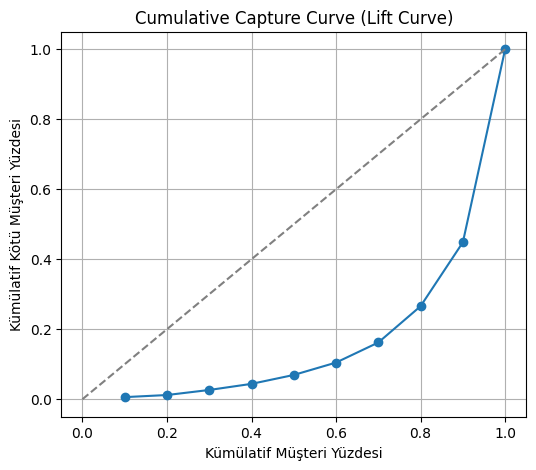

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(decile_stats["cum_customers_pct"], decile_stats["cum_bads_pct"], marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")  # random baseline
plt.xlabel("Kümülatif Müşteri Yüzdesi")
plt.ylabel("Kümülatif Kötü Müşteri Yüzdesi")
plt.title("Cumulative Capture Curve (Lift Curve)")
plt.grid(True)
plt.show()


### Cumulative Capture Curve (Lift Curve) – Modelin Kötü Müşterileri Yakalama Gücü

Bu grafik, modelin ürettiği risk skorlarına göre müşterilerin sıralandığı **kümülatif yakalama (capture) eğrisini** gösterir.

Amaç:

- En riskli müşterileri listenin başına alabiliyor muyuz?
- Kötü müşterilerin ne kadarını, müşteri portföyünün hangi yüzdesinde yakalayabiliyoruz?

Grafik iki eğri içerir:

- **Gri çizgi (random guess):**  
  Tahmin yapmayan, tamamen rastgele davranan bir sistemin performansı.  
  %20 müşteri → yaklaşık %20 kötü,  
  %50 müşteri → yaklaşık %50 kötü,  
  yani “hiç ayrıştırmayan” referans çizgi.

- **Mavi çizgi (modelimizin performansı):**  
  Modelin en riskli gördüğü müşterilerden başlayarak yukarı doğru **kümülatif** olarak kötüleri ne kadar topladığını gösterir.

### Ana Bulgular

- **İlk %20 müşteride**, kötülerin yalnızca **%1–2** kadarı yakalanıyor.  
  → Listenin en altındaki düşük risk segmentleri oldukça temiz.

- **İlk %50 müşteride**, kötülerin sadece **~%7’si** bulunuyor.  
  → Model, düşük riskli segmentleri güvenli biçimde listenin aşağısında tutuyor.

- **Asıl kırılma son %20’lik bölgede (%80–100)** ve özellikle **son %10’luk dilimde** gerçekleşiyor.  
  Bu noktadan sonra kötü müşteri yoğunluğu hızlı şekilde artıyor.

- **En riskli %10 müşteri (10. decile)**, tüm kötülerin yaklaşık **%55’ini** içeriyor.  
  → Bu, çok güçlü bir “top-heavy risk distribution” anlamına geliyor; model kötüleri puanlamada doğru şekilde tepeye yığmış.

### İş Açısından Anlamı

- Model, **kötü müşterilerin büyük kısmını küçük bir havuzda topluyor.**  
  Bu, segment bazlı stratejiler için güçlü bir temel sağlar:

  - En riskli **%10–20** → Ek kontrol, otomatik red, düşük limit  
  - Orta segment → Manuel değerlendirme, limit optimizasyonu  
  - En güvenli **%50–60** → Hızlı onay, kampanyalar

- Bu davranış, kredi risk modelleri için en değerli yapılardan biri olan  
  **“Riskin yoğunlaşmasını doğru sıralamada görmek”** şeklinde özetlenebilir.

Model yalnızca iyi bir ayrıştırma skoru (AUC ≈ 0.87) üretmiyor;  
aynı zamanda **gerçek hayatta işe yarar segmentasyon** sağlayacak kadar tutarlı bir sıralama yapıyor.



## 18. Final Model Özeti ve Model Kaydı

Bu noktada tüm modelleme süreci tamamlanmıştır:

- Full feature engineering uygulanmış,
- XGBoost modeli cross-validation ile optimize edilmiş,
- Teknik ve business metrikler üzerinden en uygun threshold seçilmiş,
- SHAP analizi ile modelin karar mantığı açıklanmış,
- ROC/AUC ve threshold tablosu ile model tutarlılığı doğrulanmıştır.

Final model, inference ve deployment aşamalarında kullanılmak üzere
`models/xgboost_credit_risk_final.pkl` dosyasına kaydedilmiştir.

Bu paket içinde:
- Tunelenmiş XGBoost modeli (`model`)
- Seçilen optimal threshold (`threshold`)
- Eğitimde kullanılan tüm özellikler (`features`)
bulunmaktadır.


In [59]:
import joblib
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

final_artifact = {
    "model": xgb_best,
    "threshold": best_threshold,
    "features": all_feature_names
}

joblib.dump(final_artifact, MODEL_DIR / "xgboost_credit_risk_final.pkl")
print("Model kaydedildi:", MODEL_DIR / "xgboost_credit_risk_final.pkl")


Model kaydedildi: models\xgboost_credit_risk_final.pkl


In [3]:
from pathlib import Path
from src.config import PROJECT_ROOT, MODELS_DIR, FINAL_MODEL

print("=== NOTEBOOK DEBUG ===")
print("CWD (çalışma klasörü):", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODELS_DIR:", MODELS_DIR)
print("FINAL_MODEL:", FINAL_MODEL)
print("MODELS_DIR exists?:", MODELS_DIR.exists())
print("FINAL_MODEL exists?:", FINAL_MODEL.exists())


=== NOTEBOOK DEBUG ===
CWD (çalışma klasörü): c:\Users\YAĞMUR\Masaüstü\credit-risk-model\notebooks
PROJECT_ROOT: C:\Users\YAĞMUR\Masaüstü\credit-risk-model
MODELS_DIR: C:\Users\YAĞMUR\Masaüstü\credit-risk-model\models
FINAL_MODEL: C:\Users\YAĞMUR\Masaüstü\credit-risk-model\models\xgboost_credit_risk_final.pkl
MODELS_DIR exists?: True
FINAL_MODEL exists?: True
